### DATASET: Primary school temporal network data

This data set contains the temporal network of contacts between the children and teachers used in the study published in BMC Infectious Diseases 2014, 14:695. The file contains a tab-separated list representing the active contacts during 20-second intervals of the data collection. Each line has the form “t i j Ci Cj”, where i and j are the anonymous IDs of the persons in contact, Ci and Cj are their classes, and the interval during which this contact was active is [ t – 20s, t ]. If multiple contacts are active in a given interval, you will see multiple lines starting with the same value of t. Time is measured in seconds.

In [1]:
import numpy             as np 
import pandas            as pd
import xarray            as xr
import numba             as nb
import matplotlib.pyplot as plt

from   tqdm              import tqdm
from   net.layerwise     import *

#### Define methods to load data

In [2]:
_DATA_PATH      = 'data-sets/primaryschool/primaryschool.csv'
_META_DATA_PATH = 'data-sets/primaryschool/metadata_primaryschool.txt'

In [10]:
def _load_data_as_adj(data_path, meta_data_path, verbose=False):
    # Loading data and metadata
    data     = pd.read_csv(data_path, header=None, delimiter='\t', usecols=[0,1,2], names=['t','i','j','Ci','Cj'])
    metadata = np.loadtxt(meta_data_path, usecols=(0,1), dtype=str)
    # Mapping nodes labels to indexes
    idx      = np.arange(metadata.shape[0], dtype=int)
    # Numerical labels to index
    n_labels = dict( zip(metadata[:,0].astype(int),idx) )
    # Literal labels to index
    s_labels = metadata[:,1]
    # Replacing nodes labes
    data['i'] = data['i'].map(n_labels)
    data['j'] = data['j'].map(n_labels)
    # Get sources and targets
    x_s   = data.groupby('t')['i'].apply(list)
    x_t   = data.groupby('t')['j'].apply(list)
    #times = x_s.index.values 
    # Convert to array
    x_s   = x_s.values
    x_t   = x_t.values
    # Get number of nodes and time-points
    n_nodes  = len(metadata[:,0])
    n_times  = len(x_s)
    times    = np.arange(n_times, dtype=int)
    # Adjacency tensor
    A   = np.zeros((n_nodes,n_nodes,n_times))
    itr = range(len(times))
    for t in tqdm(itr) if verbose else itr:
        A[x_s[t],x_t[t],t] = A[x_t[t],x_s[t],t] = 1
        np.fill_diagonal(A[...,t],1)
    # Convert to x-array
    A = xr.DataArray( A[:,:,None,:], dims=("sources", "targets", "trials", "times"),
                         coords={"sources":s_labels, 
                                 "targets":s_labels, 
                                 "times":times}
                    )
    return A

#### Load data as adjacency tensor

In [11]:
A = _load_data_as_adj(_DATA_PATH, _META_DATA_PATH, verbose=True)

100%|██████████| 3100/3100 [00:00<00:00, 28432.97it/s]


In [5]:
# Saving snapshots of the adjacency tensor
#for t in tqdm( range(A.sizes['times']) ):
#    plt.figure(figsize=(12,10) )
#    plt.imshow(A[...,t], aspect='auto', cmap='gray', origlayerwiseower')
#    plt.savefig(f'figures/{t}.png')
#    plt.close()

### Degree and Modularity time-series

In [12]:
# Computing degree time-series
d=compute_nodes_degree(A)
# Computing modularity time-series
## Igraph
m_ig=compute_network_modularity(A, verbose=True, backend='igraph', n_jobs=1)
# Brainconn
m_bc=compute_network_modularity(A, verbose=True, backend='brainconn', n_jobs=-1)

Finding network partitions.



100%|██████████| 3100/3100 [00:03<00:00, 775.67it/s]


  0%|          |  : 0/3100 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 1170 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1720 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2370 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 3100 out of 3100 | elapsed:  3.3min finished


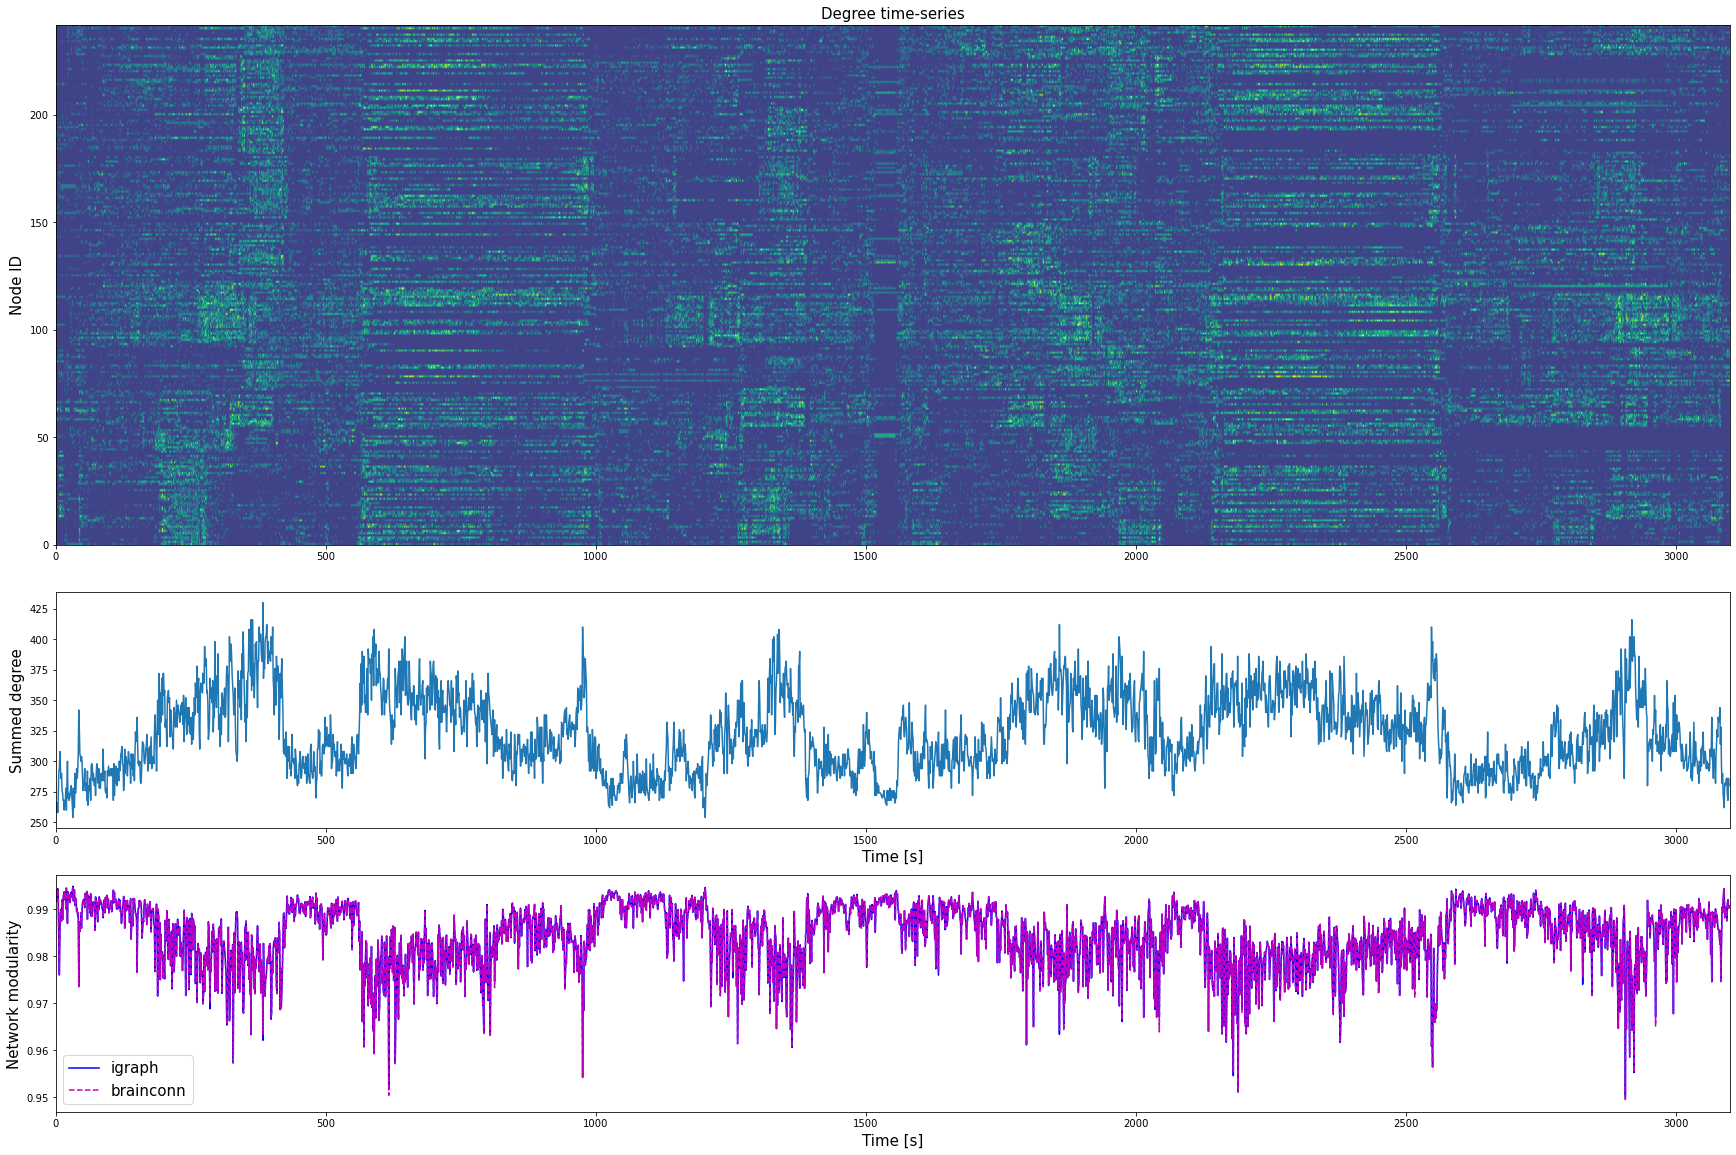

In [15]:
plt.figure(figsize=(30,20))
plt.subplot2grid((4,3),(0,0),rowspan=2,colspan=3)
plt.imshow( d.isel(trials=0), aspect='auto', cmap='viridis', origin='lower', extent=[0, A.sizes['times'], 0, A.sizes['sources']], vmin=0, vmax=5)
plt.ylabel('Node ID', fontsize=15)
#plt.yticks(range(A.sizes['sources']),A.sources.values)
plt.title('Degree time-series', fontsize=15)
plt.subplot2grid((4,3),(2,0),rowspan=1,colspan=3)
plt.plot(d.isel(trials=0).sum(dim='roi').values )
plt.xlim(0, A.sizes['times']);
plt.xlabel('Time [s]', fontsize=15)
plt.ylabel('Summed degree', fontsize=15)
plt.subplot2grid((4,3),(3,0),rowspan=1,colspan=3)
plt.plot( m_ig.isel(trials=0), 'b'  , label='igraph')
plt.plot( m_bc.isel(trials=0), 'm--', label='brainconn' )
plt.xlim(0, A.sizes['times']);
plt.xlabel('Time [s]', fontsize=15)
plt.ylabel('Network modularity', fontsize=15)
plt.legend(fontsize=15);

### Network partitions

In [16]:
# Estimating partitions using igraph
p_ig = compute_network_partition(A, verbose=False, backend='igraph', n_jobs=-1)

In [17]:
# Estimating partitions using brainconn
p_bc = compute_network_partition(A, verbose=False, backend='brainconn', n_jobs=-1)

  0%|          |  : 0/3100 [00:00<?,       ?it/s]

Text(0.5, 1.0, 'Affiliation vector - Brainconn')

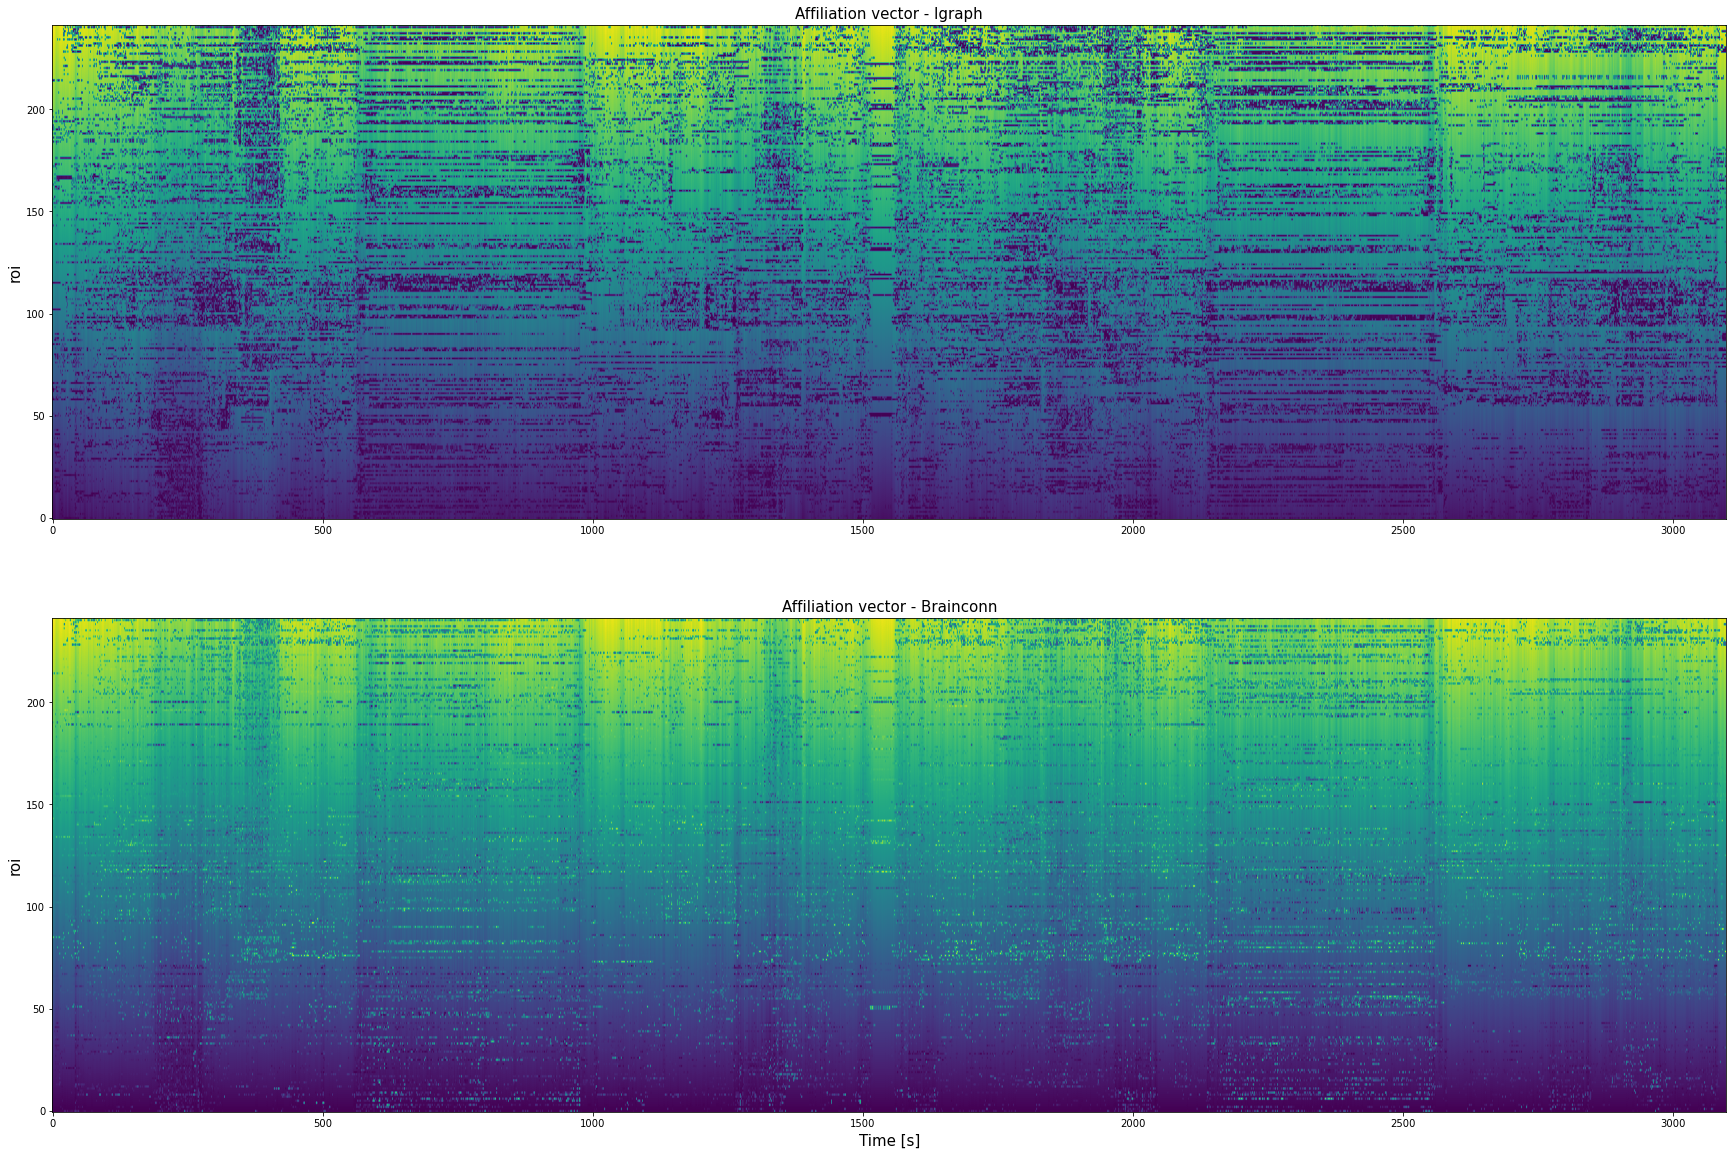

In [27]:
plt.figure(figsize=(30,20))
plt.subplot(2,1,1)
plt.imshow(p_ig.isel(trials=0), aspect='auto', cmap='viridis', origin='lower')
plt.ylabel('roi', fontsize=15)
plt.title('Affiliation vector - Igraph', fontsize=15)
plt.subplot(2,1,2)
plt.imshow(p_bc.isel(trials=0), aspect='auto', cmap='viridis', origin='lower')
plt.xlabel('Time [s]', fontsize=15)
plt.ylabel('roi', fontsize=15)
plt.title('Affiliation vector - Brainconn', fontsize=15)

#### Nodes' allegiance matrix

In [28]:
T_ig = compute_allegiance_matrix(A, verbose=False, backend='igraph', n_jobs=1)

  0%|          |  : 0/3100 [00:00<?,       ?it/s]

In [29]:
T_bc = compute_allegiance_matrix(A, verbose=False, backend='brainconn', n_jobs=-1)

  0%|          |  : 0/3100 [00:00<?,       ?it/s]

  0%|          |  : 0/3100 [00:00<?,       ?it/s]

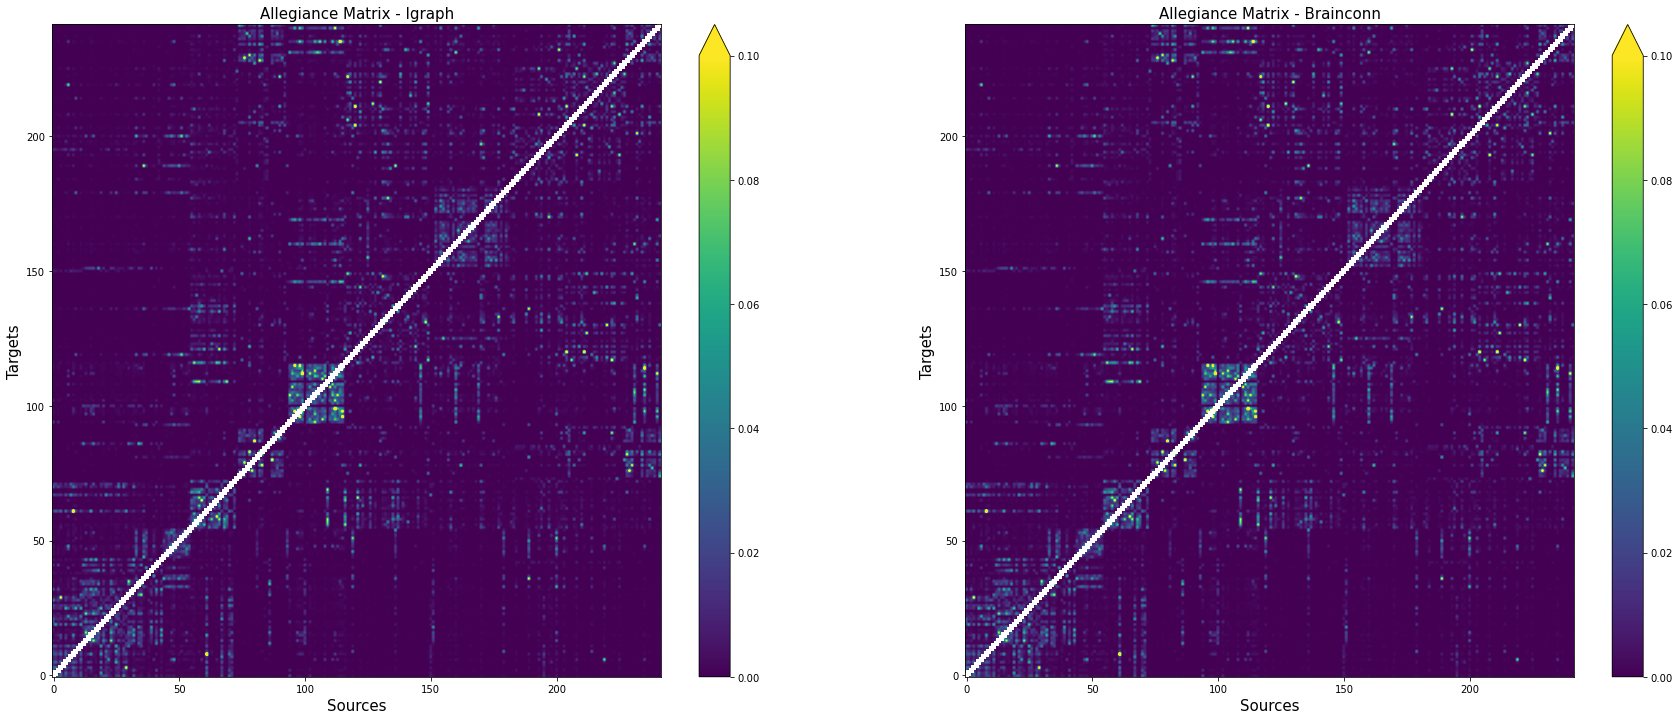

In [30]:
plt.figure(figsize=(30,12))
plt.subplot(1,2,1)
np.fill_diagonal(T_ig.values,np.nan)
plt.imshow(T_ig, aspect="auto",cmap="viridis",origin="lower", vmin=0, vmax=0.1)
#plt.xticks(range(T_ig.sizes['sources']),T_ig.sources.values, rotation=270)
#plt.yticks(range(T_ig.sizes['sources']),T_ig.targets.values)
plt.title('Allegiance Matrix - Igraph', fontsize=15)
plt.xlabel('Sources', fontsize=15)
plt.ylabel('Targets', fontsize=15)
plt.colorbar(extend='max');
plt.subplot(1,2,2)
np.fill_diagonal(T_bc.values,np.nan)
plt.imshow(T_bc, aspect="auto",cmap="viridis",origin="lower", vmin=0, vmax=0.1)
#plt.xticks(range(T_ig.sizes['sources']),T_ig.sources.values, rotation=270)
#plt.yticks(range(T_ig.sizes['sources']),T_ig.targets.values)
plt.title('Allegiance Matrix - Brainconn', fontsize=15)
plt.xlabel('Sources', fontsize=15)
plt.ylabel('Targets', fontsize=15)
plt.colorbar(extend='max');

#### Windowed nodes' allegiance matrix

In [13]:
WT_ig = windowed_allegiance_matrix(A, times=A.times.values, verbose=False, win_args=dict(slwin_len=20, slwin_step=10), backend='igraph', n_jobs=1)

Defining temporal windows
    Definition of sliding windows (len=20, start=0, stop=3099, step=10)
    308 windows defined


  0%|          |  : 0/1 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

In [ ]:
WT_bc = windowed_allegiance_matrix(A, times=A.times.values, verbose=False, win_args=dict(slwin_len=20, slwin_step=10), backend='brainconn', n_jobs=-1)

In [14]:
for t in tqdm( range( WT_ig.sizes['times'] ) ):
    plt.figure(figsize=(15,12))
    np.fill_diagonal(WT_ig.values[:,:,0,t],np.nan)
    plt.imshow(WT_ig.values[:,:,0,t],aspect='auto',origin='lower',cmap='viridis', vmin=0, vmax=0.5)
    plt.title(f'Allegiance Matrix, t={WT_ig.times.values[t]}', fontsize=15)
    plt.xlabel('Sources', fontsize=15)
    plt.ylabel('Targets', fontsize=15)
    plt.colorbar(extend='max');
    plt.savefig(f'figures/am_{t}.png')
    plt.close()

100%|██████████| 308/308 [01:07<00:00,  4.59it/s]


In [ ]:
for t in tqdm( range( WT_ig.sizes['times'] ) ):
    plt.figure(figsize=(15,12))
    np.fill_diagonal(WT_ig.values[:,:,0,t],np.nan)
    plt.imshow(WT_ig.values[:,:,0,t],aspect='auto',origin='lower',cmap='viridis', vmin=0, vmax=0.5)
    plt.title(f'Allegiance Matrix, t={WT_ig.times.values[t]}', fontsize=15)
    plt.xlabel('Sources', fontsize=15)
    plt.ylabel('Targets', fontsize=15)
    plt.colorbar(extend='max');
    plt.savefig(f'figures/am_bc_{t}.png')
    plt.close()